In [1]:
%%time
# Importing the libraries

import pandas as pd
import numpy as np
# import pandas_profiling # Needs Visual C++ 14.0 via Visual Studio Build Tools
import pyodbc
import regex as re

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt


# from scipy.stats import norm
# import scipy.stats as stats

# Importing date/time and warnings libraries

from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

Wall time: 1min 4s


In [2]:
%%time
#Reading local csv file with pandas

merge_sales_data = pd.read_csv(r'Merged_Sales_Data - Copy.csv', encoding='latin1')
merge_sales_data.head()

Wall time: 1.56 s


,SalesID,Employee_ID,CustomerID,ProductID,Quantity,Product_Name,Product_Price,Employee_Name,Employee_Middle,Employee_Lastname,Customer_Name,Customer_Middle,Customer_LastName
0,1,17.0,10482,500.0,500.0,ML Bottom Bracket,101.24,Albert,I,Ringer,Joseph,NaN,White
1,2,5.0,1964,306.0,810.0,"Road-550-W Yellow, 48",1120.49,Innes,E,del Castillo,Austin,M,Jai
2,3,8.0,12300,123.0,123.0,Lock Nut 9,177.6,Morningstar,R,Greene,Lauren,W,Cooper
3,4,1.0,4182,437.0,437.0,ML Road Tire,24.99,Abraham,E,Bennet,Clarence,L,Zeng
4,5,14.0,15723,246.0,750.0,"HL Mountain Frame - Silver, 48",$1364.5 $,Heather,C,McBadden,Preston,NaN,Perez


# Data Profiling

In [3]:
# Renaming Employee Last Name column to a uniform naming convention

merge_sales_data.rename(columns={"Employee_ID": "EmployeeID","Employee_Lastname": "Employee_LastName"}, inplace=True)
merge_sales_data.head()

,SalesID,EmployeeID,CustomerID,ProductID,Quantity,Product_Name,Product_Price,Employee_Name,Employee_Middle,Employee_LastName,Customer_Name,Customer_Middle,Customer_LastName
0,1,17.0,10482,500.0,500.0,ML Bottom Bracket,101.24,Albert,I,Ringer,Joseph,NaN,White
1,2,5.0,1964,306.0,810.0,"Road-550-W Yellow, 48",1120.49,Innes,E,del Castillo,Austin,M,Jai
2,3,8.0,12300,123.0,123.0,Lock Nut 9,177.6,Morningstar,R,Greene,Lauren,W,Cooper
3,4,1.0,4182,437.0,437.0,ML Road Tire,24.99,Abraham,E,Bennet,Clarence,L,Zeng
4,5,14.0,15723,246.0,750.0,"HL Mountain Frame - Silver, 48",$1364.5 $,Heather,C,McBadden,Preston,NaN,Perez


In [4]:
# Checking the data types, their counts and size of the DataFrame

print("The existing data types of our DataFrame:\n", merge_sales_data.dtypes)

print("\nThe count of data types of our DataFrame:\n", merge_sales_data.dtypes.value_counts())

print("\nSize of DataFrame: ", merge_sales_data.shape)

The existing data types of our DataFrame:
 SalesID                int64
EmployeeID           float64
CustomerID             int64
ProductID            float64
Quantity             float64
Product_Name          object
Product_Price         object
Employee_Name         object
Employee_Middle       object
Employee_LastName     object
Customer_Name         object
Customer_Middle       object
Customer_LastName     object
dtype: object

The count of data types of our DataFrame:
 object     8
float64    3
int64      2
dtype: int64

Size of DataFrame:  (1048519, 13)


The various numerical data types (float64 and int64) are not grouped into a single category as we would like. Also, some columns are listed as objects which is not very helpful because objects is a very broad word.

In [5]:
# Functions to perform clean grouping of the data types

def get_var_category(series):
    unique_count = series.nunique(dropna=False)
    total_count = len(series)
    if pd.api.types.is_numeric_dtype(series):
        return 'Numerical'
    elif pd.api.types.is_datetime64_dtype(series):
        return 'Date'
    elif pd.api.types.is_string_dtype(series):
        return 'String'
    elif unique_count==total_count:
        return 'Text (Unique)'
    else:
        return 'Categorical'

def print_categories(df):
    for column_name in df.columns:
        print(column_name,": ", get_var_category(df[column_name]))

print_categories(merge_sales_data)

SalesID :  Numerical
EmployeeID :  Numerical
CustomerID :  Numerical
ProductID :  Numerical
Quantity :  Numerical
Product_Name :  String
Product_Price :  String
Employee_Name :  String
Employee_Middle :  String
Employee_LastName :  String
Customer_Name :  String
Customer_Middle :  String
Customer_LastName :  String


The above output indicates the presence of blank entries and also special characters interlaced with the actual entries due to data type being string for some columns.

In [6]:
# Overall count of values for each column

merge_sales_data.count()

SalesID              1048519
EmployeeID           1048367
CustomerID           1048519
ProductID            1048515
Quantity             1048515
Product_Name         1048051
Product_Price        1048169
Employee_Name        1035623
Employee_Middle       992975
Employee_LastName    1036788
Customer_Name        1046571
Customer_Middle       563130
Customer_LastName    1046265
dtype: int64

In [7]:
# Getting the counts of Missing Values from each column

print("Count of Missing Values in: \n")
print("  SalesID: ",(len(merge_sales_data["SalesID"])-(merge_sales_data["SalesID"].count())))
print("  EmployeeID: ",(len(merge_sales_data["EmployeeID"])-(merge_sales_data["EmployeeID"].count())))
print("  CustomerID: ",(len(merge_sales_data["CustomerID"])-(merge_sales_data["CustomerID"].count())))
print("  ProductID: ",(len(merge_sales_data["ProductID"])-(merge_sales_data["ProductID"].count())))
print("  Quantity: ",(len(merge_sales_data["Quantity"])-(merge_sales_data["Quantity"].count())))
print("  Product_Name: ",(len(merge_sales_data["Product_Name"])-(merge_sales_data["Product_Name"].count())))
print("  Product_Price: ",(len(merge_sales_data["Product_Price"])-(merge_sales_data["Product_Price"].count())))
print("  Employee_Name: ",(len(merge_sales_data["Employee_Name"])-(merge_sales_data["Employee_Name"].count())))
print("  Employee_Middle: ",(len(merge_sales_data["Employee_Middle"])-(merge_sales_data["Employee_Middle"].count())))
print("  Employee_LastName: ",(len(merge_sales_data["Employee_LastName"])-(merge_sales_data["Employee_LastName"].count())))
print("  Customer_Name: ",(len(merge_sales_data["Customer_Name"])-(merge_sales_data["Customer_Name"].count())))
print("  Customer_Middle: ",(len(merge_sales_data["Customer_Middle"])-(merge_sales_data["Customer_Middle"].count())))
print("  Customer_LastName: ",(len(merge_sales_data["Customer_LastName"])-(merge_sales_data["Customer_LastName"].count())))

Count of Missing Values in: 

  SalesID:  0
  EmployeeID:  152
  CustomerID:  0
  ProductID:  4
  Quantity:  4
  Product_Name:  468
  Product_Price:  350
  Employee_Name:  12896
  Employee_Middle:  55544
  Employee_LastName:  11731
  Customer_Name:  1948
  Customer_Middle:  485389
  Customer_LastName:  2254


In [8]:
# Difference between Product_ID listed vs Product_Name logged

print ((merge_sales_data.ProductID.count() - merge_sales_data.Product_Name.count()), "Product Names are missing.")

464 Product Names are missing.


In [9]:
# Difference between unique values of Product_ID listed vs Product_Name logged

print ((merge_sales_data.Product_Name.nunique() - merge_sales_data.ProductID.nunique()), "counts of product IDs not matching up.")

2 counts of product IDs not matching up.


In [10]:
# Employee Data Description

merge_sales_data[['Employee_Name', 'Employee_Middle', 'Employee_LastName']].describe()

,Employee_Name,Employee_Middle,Employee_LastName
count,1035623,992975,1036788
unique,29,11,25
top,Abraham,E,Bennet
freq,96536,183543,97705


In [11]:
# Customer Data Description

merge_sales_data[['Customer_Name', 'Customer_Middle', 'Customer_LastName']].describe()

,Customer_Name,Customer_Middle,Customer_LastName
count,1046571,563130,1046265
unique,330,21,207
top,Victoria,L,Rodriguez
freq,17577,90879,24147


In [ ]:
%%time
# Gathering descriptive statistics via pandas-profiling library

# data_profile = pandas_profiling.ProfileReport(merge_sales_data)

# Publishes Profiling Report into an HTML File

# data_profile.to_file(output_file="Detailed_Report1.html")

In [ ]:
%%time

# Minimal version of the Profiling Report using pandas_profiling

# profile = pandas_profiling.ProfileReport(merge_sales_data, minimal=True)

# Publishes Profiling Report into an HTML File

# profile.to_file(output_file="Minimal_Report.html")

Profiling Table

<div>
<img src="Profiling%20Results%20Table.png" width="450"/>
</div>

## Data Cleaning

In [12]:
# Converting all string entries to UPPER CASE for Consistency

merge_sales_data['Product_Name'] = merge_sales_data['Product_Name'].str.upper()
merge_sales_data['Employee_Name'] = merge_sales_data['Employee_Name'].str.upper()
merge_sales_data['Employee_Middle'] = merge_sales_data['Employee_Middle'].str.upper()
merge_sales_data['Employee_LastName'] = merge_sales_data['Employee_LastName'].str.upper()
merge_sales_data['Customer_Name'] = merge_sales_data['Customer_Name'].str.upper()
merge_sales_data['Customer_Middle'] = merge_sales_data['Customer_Middle'].str.upper()
merge_sales_data['Customer_LastName'] = merge_sales_data['Customer_LastName'].str.upper()

merge_sales_data.head()

,SalesID,EmployeeID,CustomerID,ProductID,Quantity,Product_Name,Product_Price,Employee_Name,Employee_Middle,Employee_LastName,Customer_Name,Customer_Middle,Customer_LastName
0,1,17.0,10482,500.0,500.0,ML BOTTOM BRACKET,101.24,ALBERT,I,RINGER,JOSEPH,NaN,WHITE
1,2,5.0,1964,306.0,810.0,"ROAD-550-W YELLOW, 48",1120.49,INNES,E,DEL CASTILLO,AUSTIN,M,JAI
2,3,8.0,12300,123.0,123.0,LOCK NUT 9,177.6,MORNINGSTAR,R,GREENE,LAUREN,W,COOPER
3,4,1.0,4182,437.0,437.0,ML ROAD TIRE,24.99,ABRAHAM,E,BENNET,CLARENCE,L,ZENG
4,5,14.0,15723,246.0,750.0,"HL MOUNTAIN FRAME - SILVER, 48",$1364.5 $,HEATHER,C,MCBADDEN,PRESTON,NaN,PEREZ


In [13]:
%%time

# Data Cleaning: Concatenating Columns to get full names for Employees and Customers

emp_cols = ['Employee_Name', 'Employee_Middle', 'Employee_LastName']
merge_sales_data["Employee"] = merge_sales_data[emp_cols].apply(lambda x: ' '.join(x.dropna()), axis=1)

cus_cols = ['Customer_Name', 'Customer_Middle', 'Customer_LastName']
merge_sales_data["Customer"] = merge_sales_data[cus_cols].apply(lambda x: ' '.join(x.dropna()), axis=1)

merge_sales_data.head()

Wall time: 4min


,SalesID,EmployeeID,CustomerID,ProductID,Quantity,Product_Name,Product_Price,Employee_Name,Employee_Middle,Employee_LastName,Customer_Name,Customer_Middle,Customer_LastName,Employee,Customer
0,1,17.0,10482,500.0,500.0,ML BOTTOM BRACKET,101.24,ALBERT,I,RINGER,JOSEPH,NaN,WHITE,ALBERT I RINGER,JOSEPH WHITE
1,2,5.0,1964,306.0,810.0,"ROAD-550-W YELLOW, 48",1120.49,INNES,E,DEL CASTILLO,AUSTIN,M,JAI,INNES E DEL CASTILLO,AUSTIN M JAI
2,3,8.0,12300,123.0,123.0,LOCK NUT 9,177.6,MORNINGSTAR,R,GREENE,LAUREN,W,COOPER,MORNINGSTAR R GREENE,LAUREN W COOPER
3,4,1.0,4182,437.0,437.0,ML ROAD TIRE,24.99,ABRAHAM,E,BENNET,CLARENCE,L,ZENG,ABRAHAM E BENNET,CLARENCE L ZENG
4,5,14.0,15723,246.0,750.0,"HL MOUNTAIN FRAME - SILVER, 48",$1364.5 $,HEATHER,C,MCBADDEN,PRESTON,NaN,PEREZ,HEATHER C MCBADDEN,PRESTON PEREZ


In [14]:
merge_sales_data.shape

(1048519, 15)

In [15]:
# Removing Employee and Customer First, Middle and Last Name name columns

merge_sales_data1 = merge_sales_data
merge_sales_data1.drop(merge_sales_data.columns[[7, 8, 9, 10, 11, 12]], axis = 1, inplace = True)
merge_sales_data1.head()

,SalesID,EmployeeID,CustomerID,ProductID,Quantity,Product_Name,Product_Price,Employee,Customer
0,1,17.0,10482,500.0,500.0,ML BOTTOM BRACKET,101.24,ALBERT I RINGER,JOSEPH WHITE
1,2,5.0,1964,306.0,810.0,"ROAD-550-W YELLOW, 48",1120.49,INNES E DEL CASTILLO,AUSTIN M JAI
2,3,8.0,12300,123.0,123.0,LOCK NUT 9,177.6,MORNINGSTAR R GREENE,LAUREN W COOPER
3,4,1.0,4182,437.0,437.0,ML ROAD TIRE,24.99,ABRAHAM E BENNET,CLARENCE L ZENG
4,5,14.0,15723,246.0,750.0,"HL MOUNTAIN FRAME - SILVER, 48",$1364.5 $,HEATHER C MCBADDEN,PRESTON PEREZ


In [16]:
merge_sales_data1.shape

(1048519, 9)

In [17]:
# Drop rows where Product_Price is NaN

merge_sales_data1 = merge_sales_data1[merge_sales_data['Product_Price'].notna()]
merge_sales_data1.head()

,SalesID,EmployeeID,CustomerID,ProductID,Quantity,Product_Name,Product_Price,Employee,Customer
0,1,17.0,10482,500.0,500.0,ML BOTTOM BRACKET,101.24,ALBERT I RINGER,JOSEPH WHITE
1,2,5.0,1964,306.0,810.0,"ROAD-550-W YELLOW, 48",1120.49,INNES E DEL CASTILLO,AUSTIN M JAI
2,3,8.0,12300,123.0,123.0,LOCK NUT 9,177.6,MORNINGSTAR R GREENE,LAUREN W COOPER
3,4,1.0,4182,437.0,437.0,ML ROAD TIRE,24.99,ABRAHAM E BENNET,CLARENCE L ZENG
4,5,14.0,15723,246.0,750.0,"HL MOUNTAIN FRAME - SILVER, 48",$1364.5 $,HEATHER C MCBADDEN,PRESTON PEREZ


In [18]:
merge_sales_data1.shape

(1048169, 9)

In [19]:
merge_sales_data1.dtypes

SalesID            int64
EmployeeID       float64
CustomerID         int64
ProductID        float64
Quantity         float64
Product_Name      object
Product_Price     object
Employee          object
Customer          object
dtype: object

In [20]:
%%time
# Converting Data types of columns for Consistency

merge_sales_data1 = merge_sales_data1[merge_sales_data1['EmployeeID'].notna()] # Filters out non-NaN values

# Converting Data types of columns to Integer type

merge_sales_data1['EmployeeID'] = merge_sales_data1['EmployeeID'].astype('int64')
merge_sales_data1['ProductID'] = merge_sales_data1['ProductID'].astype('int64')
merge_sales_data1['Quantity'] = merge_sales_data1['Quantity'].astype('int64')

# Converting Data types of Product Price to Float type
merge_sales_data1['Product_Price'] = merge_sales_data1['Product_Price'].apply(lambda x: float(re.findall(r"[-+]?\d*\.\d+|\d+", str(x))[0]))

# Converting Data types of Employee and Customer names to String type

merge_sales_data1['Employee'] = merge_sales_data1['Employee'].astype('str')
merge_sales_data1['Customer'] = merge_sales_data1['Customer'].astype('str')

Wall time: 5.57 s


In [21]:
merge_sales_data1.dtypes

SalesID            int64
EmployeeID         int64
CustomerID         int64
ProductID          int64
Quantity           int64
Product_Name      object
Product_Price    float64
Employee          object
Customer          object
dtype: object

In [23]:
merge_sales_data1.head()

,SalesID,EmployeeID,CustomerID,ProductID,Quantity,Product_Name,Product_Price,Employee,Customer
0,1,17,10482,500,500,ML BOTTOM BRACKET,101.24,ALBERT I RINGER,JOSEPH WHITE
1,2,5,1964,306,810,"ROAD-550-W YELLOW, 48",1120.49,INNES E DEL CASTILLO,AUSTIN M JAI
2,3,8,12300,123,123,LOCK NUT 9,177.60,MORNINGSTAR R GREENE,LAUREN W COOPER
3,4,1,4182,437,437,ML ROAD TIRE,24.99,ABRAHAM E BENNET,CLARENCE L ZENG
4,5,14,15723,246,750,"HL MOUNTAIN FRAME - SILVER, 48",1364.50,HEATHER C MCBADDEN,PRESTON PEREZ


In [24]:
%%time
merge_sales_data1.to_csv('Concatenated_Data.csv', index = False)

Wall time: 5.16 s


In [25]:
merge_sales_data1['ProductID'].value_counts(dropna=False)

9      12264
26     12229
166    12214
149    12179
196    12146
       ...  
232      141
139      141
499      141
482      141
249      137
Name: ProductID, Length: 266, dtype: int64

In [25]:
merge_sales_data1.groupby(['EmployeeID','Employee'])['SalesID'].nunique()

EmployeeID  Employee        
1                                 546
            ABRAHAM               220
            ABRAHAM BENNET        370
            ABRAHAM E             409
            ABRAHAM E BENNET    95507
                                ...  
23          AKIKO O YOKOMOTO    16407
            AKIKO YOKOMOTO        267
            O                     233
            O YOKOMOTO            835
            YOKOMOTO               91
Name: SalesID, Length: 111, dtype: int64

In [27]:
merge_sales_data1.groupby(['EmployeeID','Employee'])['SalesID'].nunique()

EmployeeID  Employee        
1                                 546
            ABRAHAM               220
            ABRAHAM BENNET        370
            ABRAHAM E             409
            ABRAHAM E BENNET    95507
                                ...  
23          AKIKO O YOKOMOTO    16407
            AKIKO YOKOMOTO        267
            O                     233
            O YOKOMOTO            835
            YOKOMOTO               91
Name: SalesID, Length: 111, dtype: int64

In [26]:
merge_sales_data1.groupby(['CustomerID','Customer'])['ProductID'].nunique()

CustomerID  Customer        
1                               1
            AARON               1
            AARON ALEXANDER     1
            ALEXANDER           1
            AON ALEXANDER       1
                               ..
19520       WYATT THOMPSON      1
19530       WYATT C CAMPBELL    1
19600       XAVIER WHITE        1
19640       XAVIER M SMITH      1
19680       YVONNE MCKAY        1
Name: ProductID, Length: 561, dtype: int64

In [27]:
# Checking the Data Types

merge_sales_data1.dtypes

SalesID            int64
EmployeeID         int64
CustomerID         int64
ProductID          int64
Quantity           int64
Product_Name      object
Product_Price    float64
Employee          object
Customer          object
dtype: object

In [28]:
product = pd.read_excel(r'products.xlsx')
product.head()

,ProductID,Product_Name,Class
0,1,ADJUSTABLE RACE,PARTS
1,2,BEARING BALL,PARTS
2,3,BB BALL BEARING,PARTS
3,9,CHAINRING BOLTS,PARTS
4,10,CHAINRING NUT,PARTS


In [29]:
customer = pd.read_excel(r'customer.xlsx')
customer.head()

,CustomerID,Customer
0,1,AARON ALEXANDER
1,6,AARON CON
2,18,AARON LI
3,80,ABIGAIL CLARK
4,125,ABIGAIL H WOOD


In [30]:
employee = pd.read_excel(r'employee.xlsx')
employee.head()

,EmployeeID,Employee
0,1,ABRAHAM E BENNET
1,2,REGINALD L BLOTCHET-HALLS
2,3,CHERYL A CARSON
3,4,MICHEL E DEFRANCE
4,5,INNES E DEL CASTILLO


In [31]:
join1 = pd.merge(merge_sales_data1, product, on = 'ProductID')
join1.head()

,SalesID,EmployeeID,CustomerID,ProductID,Quantity,Product_Name_x,Product_Price,Employee,Customer,Product_Name_y,Class
0,1,17,10482,500,500,ML BOTTOM BRACKET,101.24,ALBERT I RINGER,JOSEPH WHITE,ML BOTTOM BRACKET,PARTS
1,17,17,10482,500,500,ML BOTTOM BRACKET,101.24,ALBERT I RINGER,JOSEPH WHITE,ML BOTTOM BRACKET,PARTS
2,84,17,10482,500,500,ML BOTTOM BRACKET,101.24,ALBERT I RINGER,JOSEPH WHITE,ML BOTTOM BRACKET,PARTS
3,151,17,10482,500,500,ML BOTTOM BRACKET,101.24,I,JOSEPH WHITE,ML BOTTOM BRACKET,PARTS
4,186,17,10482,500,500,ML BOTTOM BRACKET,101.24,I,JOSEPH WHITE,ML BOTTOM BRACKET,PARTS


In [32]:
# Creating a clean Product_Name column

join1 = join1.drop(['Product_Name_x'], axis=1)
join1 = join1.rename(columns={"Product_Name_y": "Product_Name"})
join1.head()

,SalesID,EmployeeID,CustomerID,ProductID,Quantity,Product_Price,Employee,Customer,Product_Name,Class
0,1,17,10482,500,500,101.24,ALBERT I RINGER,JOSEPH WHITE,ML BOTTOM BRACKET,PARTS
1,17,17,10482,500,500,101.24,ALBERT I RINGER,JOSEPH WHITE,ML BOTTOM BRACKET,PARTS
2,84,17,10482,500,500,101.24,ALBERT I RINGER,JOSEPH WHITE,ML BOTTOM BRACKET,PARTS
3,151,17,10482,500,500,101.24,I,JOSEPH WHITE,ML BOTTOM BRACKET,PARTS
4,186,17,10482,500,500,101.24,I,JOSEPH WHITE,ML BOTTOM BRACKET,PARTS


In [37]:
join1.head()

,SalesID,EmployeeID,CustomerID,ProductID,Quantity,Product_Price,Employee,Customer,Product_Name,Class
0,1,17,10482,500,500,101.24,ALBERT I RINGER,JOSEPH WHITE,ML BOTTOM BRACKET,PARTS
1,17,17,10482,500,500,101.24,ALBERT I RINGER,JOSEPH WHITE,ML BOTTOM BRACKET,PARTS
2,84,17,10482,500,500,101.24,ALBERT I RINGER,JOSEPH WHITE,ML BOTTOM BRACKET,PARTS
3,151,17,10482,500,500,101.24,I,JOSEPH WHITE,ML BOTTOM BRACKET,PARTS
4,186,17,10482,500,500,101.24,I,JOSEPH WHITE,ML BOTTOM BRACKET,PARTS


In [33]:
join2 = pd.merge(join1, customer, on = 'CustomerID')
join2.head()

,SalesID,EmployeeID,CustomerID,ProductID,Quantity,Product_Price,Employee,Customer_x,Product_Name,Class,Customer_y
0,1,17,10482,500,500,101.24,ALBERT I RINGER,JOSEPH WHITE,ML BOTTOM BRACKET,PARTS,JOSEPH WHITE
1,17,17,10482,500,500,101.24,ALBERT I RINGER,JOSEPH WHITE,ML BOTTOM BRACKET,PARTS,JOSEPH WHITE
2,84,17,10482,500,500,101.24,ALBERT I RINGER,JOSEPH WHITE,ML BOTTOM BRACKET,PARTS,JOSEPH WHITE
3,151,17,10482,500,500,101.24,I,JOSEPH WHITE,ML BOTTOM BRACKET,PARTS,JOSEPH WHITE
4,186,17,10482,500,500,101.24,I,JOSEPH WHITE,ML BOTTOM BRACKET,PARTS,JOSEPH WHITE


In [34]:
join2 = join2.drop(['Customer_x'], axis=1)
join2 = join2.rename(columns={"Customer_y": "Customer"})
join2.head()

,SalesID,EmployeeID,CustomerID,ProductID,Quantity,Product_Price,Employee,Product_Name,Class,Customer
0,1,17,10482,500,500,101.24,ALBERT I RINGER,ML BOTTOM BRACKET,PARTS,JOSEPH WHITE
1,17,17,10482,500,500,101.24,ALBERT I RINGER,ML BOTTOM BRACKET,PARTS,JOSEPH WHITE
2,84,17,10482,500,500,101.24,ALBERT I RINGER,ML BOTTOM BRACKET,PARTS,JOSEPH WHITE
3,151,17,10482,500,500,101.24,I,ML BOTTOM BRACKET,PARTS,JOSEPH WHITE
4,186,17,10482,500,500,101.24,I,ML BOTTOM BRACKET,PARTS,JOSEPH WHITE


In [35]:
join3 = pd.merge(join2, employee, on = 'EmployeeID')
join3.head()

,SalesID,EmployeeID,CustomerID,ProductID,Quantity,Product_Price,Employee_x,Product_Name,Class,Customer,Employee_y
0,1,17,10482,500,500,101.24,ALBERT I RINGER,ML BOTTOM BRACKET,PARTS,JOSEPH WHITE,ALBERT I RINGER
1,17,17,10482,500,500,101.24,ALBERT I RINGER,ML BOTTOM BRACKET,PARTS,JOSEPH WHITE,ALBERT I RINGER
2,84,17,10482,500,500,101.24,ALBERT I RINGER,ML BOTTOM BRACKET,PARTS,JOSEPH WHITE,ALBERT I RINGER
3,151,17,10482,500,500,101.24,I,ML BOTTOM BRACKET,PARTS,JOSEPH WHITE,ALBERT I RINGER
4,186,17,10482,500,500,101.24,I,ML BOTTOM BRACKET,PARTS,JOSEPH WHITE,ALBERT I RINGER


In [36]:
# Creating a clean Employee column

join3 = join3.drop(['Employee_x'], axis=1)
join3 = join3.rename(columns={"Employee_y": "Employee"})
join3.head()

,SalesID,EmployeeID,CustomerID,ProductID,Quantity,Product_Price,Product_Name,Class,Customer,Employee
0,1,17,10482,500,500,101.24,ML BOTTOM BRACKET,PARTS,JOSEPH WHITE,ALBERT I RINGER
1,17,17,10482,500,500,101.24,ML BOTTOM BRACKET,PARTS,JOSEPH WHITE,ALBERT I RINGER
2,84,17,10482,500,500,101.24,ML BOTTOM BRACKET,PARTS,JOSEPH WHITE,ALBERT I RINGER
3,151,17,10482,500,500,101.24,ML BOTTOM BRACKET,PARTS,JOSEPH WHITE,ALBERT I RINGER
4,186,17,10482,500,500,101.24,ML BOTTOM BRACKET,PARTS,JOSEPH WHITE,ALBERT I RINGER


In [37]:
# Removes some duplicates from overall DataFrame

# join3.groupby(join3.index).first()
join3.drop_duplicates(inplace=True)
join3.head()

,SalesID,EmployeeID,CustomerID,ProductID,Quantity,Product_Price,Product_Name,Class,Customer,Employee
0,1,17,10482,500,500,101.24,ML BOTTOM BRACKET,PARTS,JOSEPH WHITE,ALBERT I RINGER
1,17,17,10482,500,500,101.24,ML BOTTOM BRACKET,PARTS,JOSEPH WHITE,ALBERT I RINGER
2,84,17,10482,500,500,101.24,ML BOTTOM BRACKET,PARTS,JOSEPH WHITE,ALBERT I RINGER
3,151,17,10482,500,500,101.24,ML BOTTOM BRACKET,PARTS,JOSEPH WHITE,ALBERT I RINGER
4,186,17,10482,500,500,101.24,ML BOTTOM BRACKET,PARTS,JOSEPH WHITE,ALBERT I RINGER


In [38]:
join3.shape

(1047998, 10)

In [39]:
# Removing Duplicates based on multiple columns

join3.sort_values('SalesID', ascending=True)
join3 = join3.drop_duplicates(subset=['EmployeeID', 'CustomerID', 'ProductID', 'Customer', 'Employee'])
join3.head()

,SalesID,EmployeeID,CustomerID,ProductID,Quantity,Product_Price,Product_Name,Class,Customer,Employee
0,1,17,10482,500,500,101.24,ML BOTTOM BRACKET,PARTS,JOSEPH WHITE,ALBERT I RINGER
112,7902,17,6025,500,500,101.24,ML BOTTOM BRACKET,PARTS,EDUARDO J BROWN,ALBERT I RINGER
172,11694,17,973,500,500,101.24,ML BOTTOM BRACKET,PARTS,ALVIN V ZHENG,ALBERT I RINGER
5720,12,17,14664,433,937,24.99,LL MOUNTAIN TIRE,PARTS,MORGAN M HILL,ALBERT I RINGER
5826,7930,17,8327,433,937,24.99,LL MOUNTAIN TIRE,PARTS,ISABELLE K HENDERSON,ALBERT I RINGER


In [40]:
join3 = join3.sort_values('SalesID', ascending=True)
join3.head()

,SalesID,EmployeeID,CustomerID,ProductID,Quantity,Product_Price,Product_Name,Class,Customer,Employee
0,1,17,10482,500,500,101.24,ML BOTTOM BRACKET,PARTS,JOSEPH WHITE,ALBERT I RINGER
132916,2,5,1964,306,810,1120.49,"ROAD-550-W YELLOW, 48",PRODUCT,AUSTIN M JAI,INNES E DEL CASTILLO
258184,3,8,12300,123,123,177.60,LOCK NUT 9,PARTS,LAUREN W COOPER,MORNINGSTAR R GREENE
304867,4,1,4182,437,437,24.99,ML ROAD TIRE,PARTS,CLARENCE L ZENG,ABRAHAM E BENNET
403877,5,14,15723,246,750,1364.50,"HL MOUNTAIN FRAME - SILVER, 48",PARTS,PRESTON PEREZ,HEATHER C MCBADDEN


In [41]:
join3.shape

(660, 10)

In [42]:
# Writing the cleaned data onto an Excel file for further use

join3.to_csv('Cleaned_Data.csv', index = False)

In [43]:
join3.dtypes

SalesID            int64
EmployeeID         int64
CustomerID         int64
ProductID          int64
Quantity           int64
Product_Price    float64
Product_Name      object
Class             object
Customer          object
Employee          object
dtype: object

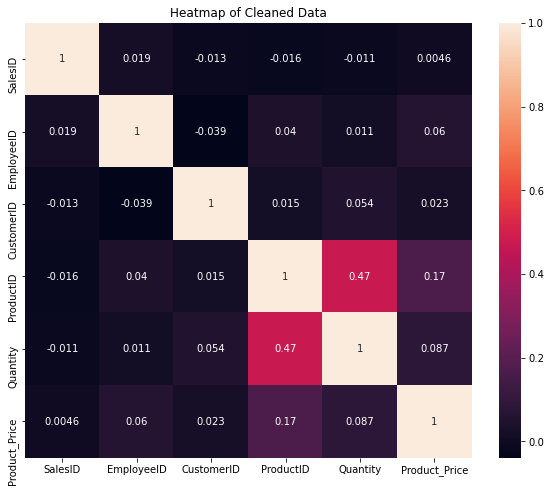

In [44]:
# Heatmap of Cleaned Data

plt.figure(figsize=(10,8))
corr=join3.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True)
plt.title('Heatmap of Cleaned Data')
plt.show()

## Creating Pipeline to SQL Server and generating a Star Schema

In [ ]:
# Setting up SQL connection

import sqlalchemy
import pyodbc
engine = sqlalchemy.create_engine("mssql+pyodbc://scott:tiger@my_db")

# write the DataFrame to a table in the sql database
join3.to_sql("my_data", engine)

In [ ]:
%%time
# Connecting to SQL DB for further querying

conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=DESKTOP-O8IQM5N\SQLEXPRESS;'
                      'Database=AdventureWorksDW2017;'
                      'Trusted_Connection=yes;')


In [ ]:
# SQL query to get production cost and sales amount

query1 = """SELECT distinct F.ProductKey, F.TotalProductCost, F.ExtendedAmount, F.OrderQuantity,
            F.SalesAmount, Year(F.OrderDate) as OrderYear, P.EnglishProductName, C.EnglishProductCategoryName,
            S.EnglishProductSubcategoryName
            FROM FactResellerSales F 
                JOIN DimProduct P on F.ProductKey = P.ProductKey
                    JOIN DimProductSubcategory S on S.ProductSubcategoryKey = P.ProductSubcategoryKey
                        JOIN DimProductCategory C on C.ProductCategoryKey = S.ProductCategoryKey
                            ORDER BY F.ProductKey, Year(F.OrderDate)"""

df_sql1 = pd.read_sql(query1, conn)
df_sql1.head()

In [ ]:
join3.head()

# Using MongoDB as the Database component

In [45]:
%%time

#Initialising the Mongo Client connection and storing the data into MongoDB server

import pymongo
from pymongo import MongoClient

client = MongoClient("mongodb://localhost:27017/")
mydb = client.Sales_Table

mycol = mydb.sales_data
records_ = join3.to_dict(orient = 'records')
result = mydb.sales_data.insert_many(records_)

Wall time: 3.25 s


In [46]:
%%time

#Accessing MongoDB data with pandas

df_data = pd.DataFrame(list(mydb.sales_data.find({})))
df_data.head()

Wall time: 199 ms


,_id,SalesID,EmployeeID,CustomerID,ProductID,Quantity,Product_Price,Product_Name,Class,Customer,Employee
0,5f3c43377d0ea771f93f4669,1,17,10482,500,500,101.24,ML BOTTOM BRACKET,PARTS,JOSEPH WHITE,ALBERT I RINGER
1,5f3c43377d0ea771f93f466a,2,5,1964,306,810,1120.49,"ROAD-550-W YELLOW, 48",PRODUCT,AUSTIN M JAI,INNES E DEL CASTILLO
2,5f3c43377d0ea771f93f466b,3,8,12300,123,123,177.60,LOCK NUT 9,PARTS,LAUREN W COOPER,MORNINGSTAR R GREENE
3,5f3c43377d0ea771f93f466c,4,1,4182,437,437,24.99,ML ROAD TIRE,PARTS,CLARENCE L ZENG,ABRAHAM E BENNET
4,5f3c43377d0ea771f93f466d,5,14,15723,246,750,1364.50,"HL MOUNTAIN FRAME - SILVER, 48",PARTS,PRESTON PEREZ,HEATHER C MCBADDEN


## Processing and Analysis

In [47]:
%%time
import pandas as pd
import numpy as np
from pandas import DataFrame

from itertools import cycle, islice

# for machine learning algorithms

import sklearn
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier

# for visualisation
import seaborn as sns
import matplotlib.pyplot as plt

Wall time: 18.3 s


In [48]:
# Getting total sales

df_data["Total_Sales"] = df_data["Quantity"] * df_data["Product_Price"]


In [49]:
# Analysing Employee Sales

df_data.groupby(["Employee"]).sum().sort_values("Product_Price", ascending=False)

,SalesID,EmployeeID,CustomerID,ProductID,Quantity,Product_Price,Total_Sales
Employee,,,,,,,
ALBERT I RINGER,10721228,578,344091,10251,19315,27563.115,1.390561e+07
ABRAHAM E BENNET,20319246,57,555597,15569,28178,25668.695,1.274946e+07
DIRK T STRINGER,9477072,567,247302,6257,11287,25571.690,1.442445e+07
MORNINGSTAR R GREENE,10440227,240,355147,7163,14215,21216.290,1.152221e+07
MICHEL E DEFRANCE,10631162,112,270016,7261,14315,19765.600,9.084605e+06
DEAN T STRAIGHT,13420458,700,354064,8638,16196,18094.490,9.155025e+06
HEATHER C MCBADDEN,9666403,406,280374,7549,15106,18071.410,1.249929e+07
MARJORIE R GREEN,9910651,203,269079,7256,13800,15776.590,7.763887e+06
JOHNSON H WHITE,10504751,682,297161,8827,15881,15721.245,8.764542e+06


In [50]:
# Grouping the products based on their Class/Category

prodclass = df_data.groupby(["Class", "Product_Name"]).sum()
prodclass.head()

SalesID  EmployeeID  CustomerID  ProductID  \
Class     Product_Name                                                  
ACCESSORY AWC LOGO CAP       19530          30       37620        651   
          CLASSIC VEST, L   514734          12        6320        371   
          CLASSIC VEST, M   881989          12       22602        740   
          CLASSIC VEST, S   571336          76       34229       1476   
          DECAL 1          2633607          30       15047         56   

                           Quantity  Product_Price  Total_Sales  
Class     Product_Name                                           
ACCESSORY AWC LOGO CAP          651          26.97      5852.49  
          CLASSIC VEST, L       876          63.50     55626.00  
          CLASSIC VEST, M      1746         127.00    110871.00  
          CLASSIC VEST, S      3493         254.00    221805.50  
          DECAL 1                55         780.00     10725.00

In [51]:
prodclass.tail()

SalesID  EmployeeID  CustomerID  ProductID  \
Class   Product_Name                                                          
PRODUCT TOURING-3000 BLUE, 62     514740          10       17600        465   
        TOURING-3000 YELLOW, 50    19566          21       26601       1401   
        TOURING-3000 YELLOW, 54  2792473          58       54876       1872   
        TOURING-3000 YELLOW, 58   459820          13        6880        469   
        TOURING-3000 YELLOW, 62   514708          14       16880        470   

                                 Quantity  Product_Price  Total_Sales  
Class   Product_Name                                                   
PRODUCT TOURING-3000 BLUE, 62         970         742.35    720079.50  
        TOURING-3000 YELLOW, 50      1401        2227.05   1040032.35  
        TOURING-3000 YELLOW, 54      1871        2969.40   1388936.85  
        TOURING-3000 YELLOW, 58       467         742.35    346677.45  
        TOURING-3000 YELLOW, 62       470         742.35    348904.50

In [52]:
# Finding the Top-5 highest selling products across each category

total_price = prodclass["Total_Sales"].groupby(level=0, group_keys=False)
total_price.nlargest(5)

Class      Product_Name                  
ACCESSORY  REFLECTOR                          1867140.00
           PAINT - BLACK                       470450.40
           SHORT-SLEEVE CLASSIC JERSEY, S      240363.48
           CLASSIC VEST, S                     221805.50
           HEADLIGHTS - WEATHERPROOF           192872.13
PARTS      HL MOUNTAIN FRAME - SILVER, 48     5119604.00
           HL ROAD FRAME - RED, 56            3136416.50
           HL MOUNTAIN FRAME - SILVER, 46     2720813.00
           LL SPINDLE/AXLE                    2051415.20
           HL MOUNTAIN FRAME - SILVER, 42     2038563.00
PRODUCT    MOUNTAIN-100 SILVER, 38           13266760.98
           ROAD-350-W YELLOW, 42             10037541.99
           MOUNTAIN-200 BLACK, 46             7284298.26
           ROAD-250 RED, 44                   6047291.25
           MOUNTAIN-300 BLACK, 48             5800626.29
Name: Total_Sales, dtype: float64

Text(0, 0.5, '')

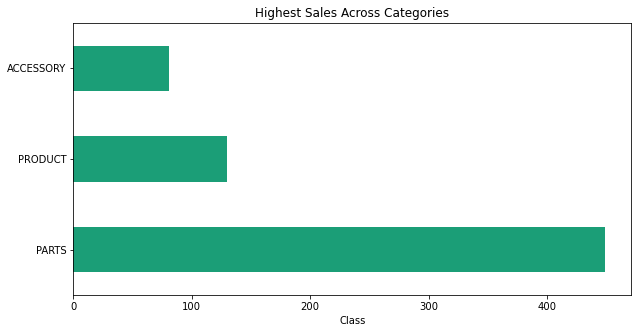

In [53]:
# Finding Highest Selling Category of Products

ax = df_data['Class'].value_counts().plot(kind='barh',
                                    figsize=(10,5),
                                    colormap='Dark2',
                                    title="Highest Sales Across Categories")
ax.set_xlabel("Class")
ax.set_ylabel("")

Bike Parts are the highest selling products across the board. This is due to bicycles undergoing constant wear and tear

Text(0, 0.5, '')

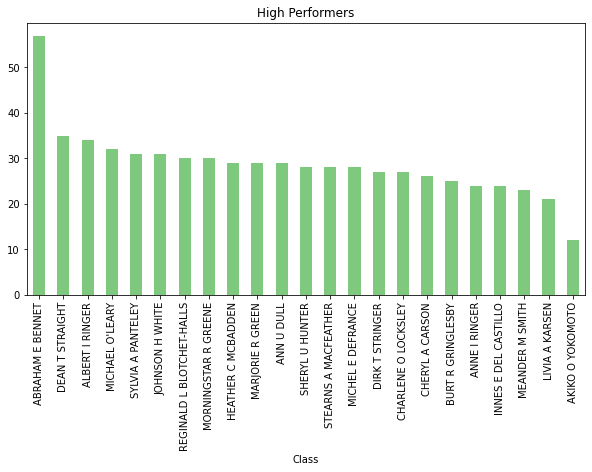

In [54]:
# Finding Top Employees

ax1 = df_data['Employee'].value_counts().plot(kind='bar',
                                    figsize=(10,5),
                                    colormap='Accent',                                    
                                    title="High Performers")
ax1.set_xlabel("Class")
ax1.set_ylabel("")

Text(0, 0.5, 'Volume (in Thousand)')

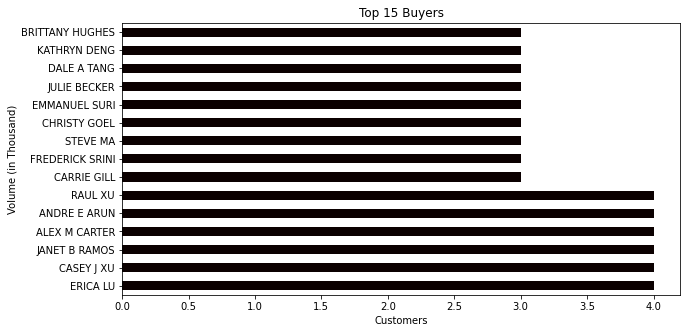

In [55]:
# Finding Top Customers

ax2 = df_data['Customer'].value_counts()[:15].plot(kind='barh',
                                    figsize=(10,5),
                                    sort_columns=True,
                                    colormap='hot',
                                    title="Top 15 Buyers")
ax2.set_xlabel("Customers")
ax2.set_ylabel("Volume (in Thousand)")

In [56]:
emp_sales=df_data[['Total_Sales','Quantity']]
emp_sales

,Total_Sales,Quantity
0,50620.00,500
1,907596.90,810
2,21844.80,123
3,10920.63,437
4,1023375.00,750
...,...,...
655,206709.36,264
656,0.00,184
657,718344.90,294
658,77897.82,231


# Applying K-Means Clustering to decide Employee Incentives

In [57]:
empmat = emp_sales.to_numpy()
empmat

array([[5.06200000e+04, 5.00000000e+02],
       [9.07596900e+05, 8.10000000e+02],
       [2.18448000e+04, 1.23000000e+02],
       ...,
       [7.18344900e+05, 2.94000000e+02],
       [7.78978200e+04, 2.31000000e+02],
       [1.82222206e+06, 7.94000000e+02]])

In [58]:
kmeans_model_emp = KMeans(n_clusters=3, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0)
emp_kmeans = kmeans_model_emp.fit_predict(empmat)

In [59]:
emp_kmeans

array([1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 2, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 2,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 2, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 2, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [60]:
sklearn.metrics.silhouette_score(emp_sales, emp_kmeans, metric='euclidean')

0.774014719901045

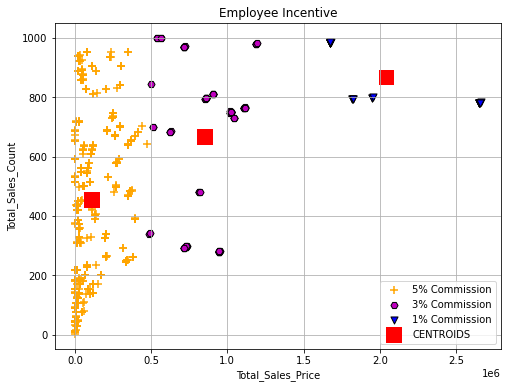

In [61]:
# Plot clusters to decide incentives employees based on Sales

plt.figure(figsize=(8,6))

plt.scatter(
    empmat[emp_kmeans == 1, 0], empmat[emp_kmeans == 1, 1],
    s=50, c='orange',
    marker='+', edgecolor=None,
    label='5% Commission'
)

plt.scatter(
    empmat[emp_kmeans == 0, 0], empmat[emp_kmeans == 0, 1],
    s=50, c='m',
    marker='H', edgecolor='black',
    label='3% Commission'
)

plt.scatter(
    empmat[emp_kmeans == 2, 0], empmat[emp_kmeans == 2, 1],
    s=50, c='blue',
    marker='v', edgecolor='black',
    label='1% Commission'
)

# plot the centroids
plt.scatter(
    kmeans_model_emp.cluster_centers_[:, 0], kmeans_model_emp.cluster_centers_[:, 1],
    s=250, marker='s',
    c='red', edgecolor='',
    label='CENTROIDS'
)
plt.legend(scatterpoints=1)
plt.grid()
plt.title('Employee Incentive')
plt.xlabel('Total_Sales_Price')
plt.ylabel('Total_Sales_Count')
plt.show()

## End of Notebook